In [214]:
#IMPORTING LIBRARIES

import scipy.special as sp # UNUSED?
import numpy as np # NumPy offers comprehensive mathematical functions, random number generators, linear algebra routines, Fourier transforms, and more
import matplotlib.pyplot as plt # Provides a MATLAB-like way of plotting
import pandas as pd # Data analysis and manipulation tool. Used to read in bathymetry data (M77T file), Directions data (excel file), and organises Vmean into a labelled data structure
# M77T data files are created from raw data collected by marine researchers using InfoBank
from scipy.interpolate import CubicSpline as SP # Used to create a spline about the velocity, shape parameter and proability data
from scipy.optimize import minimize,least_squares,Bounds,basinhopping # Optimizing and route finding
from scipy.special import gamma # Gamma function used for weibull distribution
import matplotlib.cm as cm # UNUSED?
from Boruvka_Mod import Graph # imports class graph from Boruvka_Mod python file
import utm # Used to help convert latitude and longitude in bathymetry data to centred eastings and northings
import scipy.interpolate as spline # Used to smooth the bathymetry data
from matplotlib.colors import ListedColormap # UNUSED?
import math # Provides access to the mathematical functions
from time import perf_counter # Returns the float value of time in seconds. Used to record run time for clustering and optimization algorithms
from minmax_kmeans import minsize_kmeans # imports minsize_kmeans function from minmax_kmeans python file
import pulp #Used in the clustering algorithm to generate MPS and LP files
import scipy.signal as signal #Signal package
from scipy.signal import savgol_filter

# modules installed

In [215]:
#READING IN BATHYMETRY DATA

data = pd.read_csv("nsea86.m77t", sep='\t') # Reads in all data from file including depth data, lattitude, longitude etc.
mindepth = min(data['CORR_DEPTH']) # Retrieves minimum depth value from data file 'nsea86.m77t'
print('Shallowest depth:', mindepth, 'm') #Prints out the result for the smallest depth value

Shallowest depth: 17.2 m


In [216]:
# KEY COSTING PARAMETERS USED THROUGHOUT MODEL

USDtoGBP = 1/1.351  
EURtoGBP = 1/1.19

IACableCostperMeter = 1000 # in GBP # Inter-array cable cost per metre (HVAC 33kV inter-array to substation)
HVACCableCostperMeter = 2500 # in GBP # Export cable cost per meter (HVAC 275kV substation to shore)
HVDCCableCostperMeter = 1100 # in GBP # Export cable cost per meter (VSC-HVDC 320kV substation to shore)

CostperTurbineUSD = 3000000 # USD
CostperTurbine = CostperTurbineUSD*USDtoGBP # GBP

OperatingandMaintenanceCostsperAnnum = 65500 # GBP
LifeTimeTurbineOperatingTime = 20 # years 120000 # hours
MaintenanceCostperTurbine = OperatingandMaintenanceCostsperAnnum*LifeTimeTurbineOperatingTime # in GBP

LandCostperHectare = 17245 # in GBP
LandCostpermSquared = LandCostperHectare/10000 #  in GBP

OffshoreSubstationCostperMW = 104000*EURtoGBP
OnshoreSubstationCostperMW = 87250*EURtoGBP
# Costs  associated with the purchase and installation of electrical substations as well as the buildings required for housing the staff and additional equipment required for the running of the wind farm.

ElectricityCostperkWh = 0.144 # 14.4 pence - £0.144
DiscountRate = 0.07 # 7%

In [217]:
#USER DEFINED VALUES

maximumturbinespertree = 10 # number of turbines allowed along a single cable from the substation.
budget = 100000000 # Budget in £ to build the wind farm, accounting for construction costs.
DistanceToShore = 15000 # m #distance of the wind farm from shore
TooCloseShore = 7500 # m # minimum distance the wind farm must be from shore

In [218]:
###CALCULATES THE INITIAL NUMBER OF TURBINES THE OPTIMISATION SHOULD START WITH.

maxnodespertree = maximumturbinespertree # As above

a = 350 # minimum distances turbines can be from one another in m.
b = 3000 # distance that turbines have negligible affect on eachother in m. If model changes this value could change
minareaperturbine = (1/2)*(math.sqrt(3))*(a**2) # Area per turbine assuming 350m between each turbine
LandCostperTurbine=minareaperturbine*(LandCostpermSquared) # Cost with minimum area
MinDepthCostPerTurbine = CostperTurbine*(0.0002*(float(mindepth)**2) - 0.0002*(float(mindepth)) + 0.9459)-CostperTurbine # Uses shallowest depth from before
print('Min depth cost per turbine = £',MinDepthCostPerTurbine) # prints result
MinIACableCostPerTurbine = a*IACableCostperMeter # Min inter array cable costs

MinCostperTurbTotWE = CostperTurbine+LandCostperTurbine+MaintenanceCostperTurbine+MinDepthCostPerTurbine+MinIACableCostPerTurbine # Total costs
nnturb = (budget)/(MinCostperTurbTotWE)# number of possible turbines with current budget
MinExportCableCostPerTurbine = (TooCloseShore*HVACCableCostperMeter)/nnturb
FixedCost = (OffshoreSubstationCostperMW+OnshoreSubstationCostperMW)*nnturb*2 # *2 due to 2MW turbines being used
MinCostperTurbTot = MinCostperTurbTotWE+MinExportCableCostPerTurbine
nturb = (budget-FixedCost)/(MinCostperTurbTot)
nturb = math.floor(nturb) # rounds down as cannot have fraction of a turbine
minarea = minareaperturbine*nturb # Overall minimum area considering the amount of turbines
maxarea = nturb*(1/2)*(math.sqrt(3))*(b**2) # Careful this isn't bigger than the entire size of the scaled nsea86 sea floor.

RatedPower = 2000000
EstimatedPowerOutput = RatedPower*nturb*0.5 # assumes 50% efficiency

print('Min area per turbine =', minareaperturbine, 'm^2') # prints results
print('Min area =', minarea, 'm^2')
print('Max number of turbines =', nturb)
print('Max area =', maxarea, 'm^2')

Min depth cost per turbine = £ 3615.099925980903
Min area per turbine = 106088.11196359372 m^2
Min area = 2015674.1273082807 m^2
Max number of turbines = 19
Max area = 148090344.047139 m^2


In [219]:
#PRE-OPTIMISATION TURBINE POSITIONING

# places substation at (0,0).
# places 1st turbine at vector (a,0) from substation. a=350m from before
# places 2nd turbine at vector (0.5a,0.5aroot3) from prev. 
# places 3rd turbine at vector (-a,0) from prev
# places 4th turbine at vector (-0.5a,-0.5aroot3) from prev, continues in this spiralling fashion

positionlist = np.empty((nturb+1,2)) # Creates an empty list of size (number of turbines + 1 (since 0 position is substation),2)
turbineposition = np.array([[0,0]]) # Creates [0,0] array for introducing [x,y] coordinates for each turbine
positionlist[0,:] = turbineposition # 

oddcounter = 0
evencounter = 0
i = 0
k = 0

while k<nturb+1: # Loops for number of turbines 
    i += 1
    if (i%2)!= 0: # i is odd
        oddcounter+=1 
        for j in range(oddcounter):
            k += 1
            if k == nturb+1:
                break
            if (oddcounter%2)!= 0: #oddcounter is odd
                shift = np.array([[a, 0]])
            else:
                shift = np.array([[-a, 0]])
            turbineposition = np.add(turbineposition, shift)
            positionlist[k,:] = turbineposition
            
    else:
        evencounter+=1
        for j in range(evencounter):
            k += 1
            if k == nturb+1:
                break
            if (evencounter%2)!= 0: #evencounter is odd
                shift = np.array([[0.5*a,0.5*a*math.sqrt(3)]])
            else:
                shift = np.array([[-0.5*a,-0.5*a*math.sqrt(3)]]) 
            turbineposition = np.add(turbineposition, shift)
            positionlist[k,:] = turbineposition
                
print(positionlist) # prints positions data        
print(len(positionlist)) # prints length of positions list (should be the number of turbines + 1 for the subsation)
np.savetxt("example_positions.csv", positionlist, delimiter=",")

[[   0.            0.        ]
 [ 350.            0.        ]
 [ 525.          303.10889132]
 [ 175.          303.10889132]
 [-175.          303.10889132]
 [-350.            0.        ]
 [-525.         -303.10889132]
 [-175.         -303.10889132]
 [ 175.         -303.10889132]
 [ 525.         -303.10889132]
 [ 700.            0.        ]
 [ 875.          303.10889132]
 [1050.          606.21778265]
 [ 700.          606.21778265]
 [ 350.          606.21778265]
 [   0.          606.21778265]
 [-350.          606.21778265]
 [-525.          303.10889132]
 [-700.            0.        ]
 [-875.         -303.10889132]]
20


In [220]:
# Shoreline implementation

minvalue = np.amin(positionlist, axis=0) #finds min value for each column of turbine positions
maxvalue = np.amax(positionlist, axis=0) #finds max value for each column of turbine positions
FurthestLeft = minvalue[0] # min x value
FurthestRight = maxvalue[0] # max x value
FurthestTop = maxvalue[1] # max y value
FurthestBottom = minvalue[1] #min y value
    
XShoreLine = np.array([np.linspace(FurthestLeft-2500,FurthestRight+2500,1000)]) #Creates x coordinates of shoreline bewtween min and max turbine locations +/- 1000m
#YShoreLine = np.random.randint(-DistanceToShore-200,-DistanceToShore+200,1000) #Randomy coordinates +/- 200 from distancetoshore
YShoreLine = np.array([np.linspace(-DistanceToShore,-DistanceToShore,1000)])
#xTYShoreLine = YShoreLine.reshape(1000,1) # reshapes y coordinates (transpose essentially)
TXShoreLine = np.transpose(XShoreLine) #transpose of x coordinates
TYShoreLineSmooth = np.transpose(YShoreLine)
#TYShoreLine = xTYShoreLine[:,0] # in order to be able to smooth the data
#def smooth(TYShoreLine, box_pts): #Smoothens y coordinate data
 #   box = np.ones(box_pts)/box_pts
  #  y_smooth = np.convolve(TYShoreLine, box, mode='same')
   # return y_smooth

# smooth(TYShoreLine,x) larger x would result in a greater smoothness of the shore line
#TYShoreLineSmooth = smooth(TYShoreLine,50).reshape(1000,1) # Reverts back to orginal form with now smoothen data
TShoreLine = np.concatenate((TXShoreLine,TYShoreLineSmooth),axis=1) # Shoreline (x,y)

print(FurthestLeft)
print(FurthestRight)
print(FurthestTop)
print(FurthestBottom)

-875.0
1050.0
606.217782649107
-303.1088913245535


In [221]:
# Connects Substatation to shore
# Finds minimum distance between substation and shore
a=0

def Substation_To_Shore_Connection(positionlist):

    MinDistanceSubShore = np.sqrt(((positionlist[0,0]-TXShoreLine)**2)+((positionlist[0,1]-TYShoreLineSmooth)**2)) # min Hypotenuse for distances between substation and shore
    MinDistance = float(min(MinDistanceSubShore))
    MinDistanceIndex = np.argmin(MinDistanceSubShore) # Finds index associated with minimum distance to substation form shore
    OnshoreSubstation1D = TShoreLine[MinDistanceIndex,:] #Accesses x,y values located on shore with the minimum distance found 
    OnshoreSubstation = OnshoreSubstation1D.reshape(1,2) #Converts shape from (2,) to (1,2) or 1D to 2D
    
            # Determines which cable to use and associated prices
    if MinDistance > 100000 or EstimatedPowerOutput > 200000000: # >100km or >200MW capacity
        ExportCableCostperMeter = HVDCCableCostperMeter #HVDC cable for distances abvoe 250km and power output above 200MW
    else:
        ExportCableCostperMeter = HVACCableCostperMeter #HVAC cable used for distances below 250kM and power output below 200MW
    
    ExportCableCost = (MinDistance*ExportCableCostperMeter) # Export cable cost
    
    return OnshoreSubstation,ExportCableCost

OnshoreSubstation,ExportCableCost = Substation_To_Shore_Connection(positionlist) #Initially Executes algorithm

print(OnshoreSubstation)
print(np.shape(OnshoreSubstation))

[[ 8.50850851e-01 -1.50000000e+04]]
(1, 2)


In [222]:
# Pushes wind farm further out if the smallest distance between the shore and center of wind farm is too small
# Only used for the pre-optimised layout
#In terms of keeping it this way there are bounds on (minimize(targetfunction, initial guess, bounds,.....etc.) the optimization function

CloseTurbY = min(positionlist[:,1]) # y coordinate of closest turbine
CloseTurbYindex = np.argmin(positionlist[:,1]) # index from closest turbine on y axis
CloseTurbX = positionlist[CloseTurbYindex,0] # x coordinate of closest turbine on y axis
DistanceToMinTurb = min(np.sqrt((CloseTurbX-TXShoreLine[:,0])**2+(CloseTurbY-TYShoreLineSmooth[:,0])**2)) #min distance from shore to closest turbine 
s = 0

if DistanceToMinTurb < TooCloseShore: # if closest turbine is too close to the shore
    for s in range(0,nturb+1): # loops for number of turbines plus the substation
        positionlist[s,1] = positionlist[s,1] + (TooCloseShore-DistanceToMinTurb)
        # Shifts entire wind farm up by the difference to achieve the minimum distance required
    Substation_To_Shore_Connection(positionlist) #Calls function to redo substation to shore connection with new values

(-17303.108891324555, -803.1088913245535)

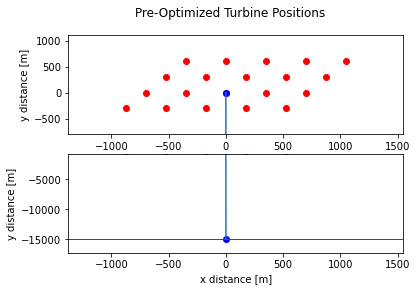

In [223]:
# Display pre-optimized turbine positions before clustering and MST

fig, (ax1,ax2) = plt.subplots(2)
fig.suptitle('Pre-Optimized Turbine Positions')

#Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)
ax1.scatter(positionlist[:,0],positionlist[:,1],c='red') # Prints turbine positions in red
ax1.scatter(positionlist[0,0],positionlist[0,1],c='blue') # offshore Substation
ax1.scatter(OnshoreSubstation[0,0],OnshoreSubstation[0,1],c='blue') #onshore substation
ax1.plot(TXShoreLine,TYShoreLineSmooth,c='green',linewidth=1) #Produces line representing the shore line in green
ax1.plot([positionlist[0,0],OnshoreSubstation[0,0]],[positionlist[0,1],OnshoreSubstation[0,1]]) #Plots Shore to substation connection
ax1.set_xlabel('x distance [m]') # x axis label
ax1.set_ylabel('y distance [m]') # y axis label
ax1.set_xlim([min(positionlist[:,0])-500, max(positionlist[:,0])+500]) #x limits
ax1.set_ylim([min(positionlist[:,1])-500, max(positionlist[:,1])+500]) #y limits 

#Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
ax2.scatter(positionlist[:,0],positionlist[:,1],c='red') # Prints turbine positions in red
ax2.scatter(positionlist[0,0],positionlist[0,1],c='blue') # offshore Substation
ax2.scatter(OnshoreSubstation[0,0],OnshoreSubstation[0,1],c='blue') #onshore substation
ax2.plot(TXShoreLine,TYShoreLineSmooth,c='green',linewidth=1) #Produces line representing the shore line in green
ax2.plot([positionlist[0,0],OnshoreSubstation[0,0]],[positionlist[0,1],OnshoreSubstation[0,1]]) #Plots Shore to substation connection
ax2.set_xlabel('x distance [m]') # x axis label
ax2.set_ylabel('y distance [m]') # y axis label
ax2.set_xlim([min(positionlist[:,0])-500, max(positionlist[:,0])+500]) #x limits
ax2.set_ylim([min(positionlist[:,1])-DistanceToShore-2000, min(positionlist[:,1])-500]) #y limits

C:\Users\adamb\anaconda3\lib\site-packages\pulp\pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Function run time: 0.12777069999992818
[[   0    1    2    3    8    9   10   11   12   13   14]
 [   0    4    5    6    7   15   16   17   18   19 -100]]


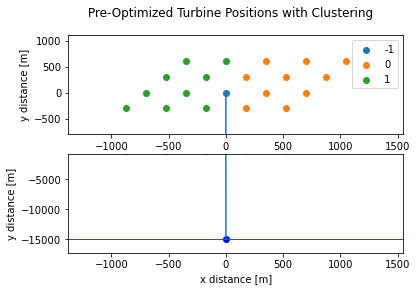

In [224]:
#CLUSTERING ALGORITHM

#Uses an adapted version of kmeans with a cap on the number of points per cluster. Used to radially cluster turbines
#into segments which MST algorithm can then use to determine cabling for a given radial array. Initially unnecessary
#for the initially structured turbine layout as seen above, but increasingly important as turbine layout becomes
#non-uniform through optimisation when the below function is repeatedly called.
# minsize_kmeans imported from external python file

def clustering_algorithm(positionlist,nturb,maxnodespertree):
    k = math.ceil(nturb/maxnodespertree) #number of clusters. math.ceil rounds a number upwards to its nearest integer
    [turbines, centres] = minsize_kmeans(positionlist[1:,:] ,k ,min_size = 1, max_size = maxnodespertree) 
    #turbines exists as an array containing the cluster value for each turbine
    #Assigns each turbine to a cluster. excludes substation, executes external python file, 
    #limits for how many turbines are in each cluster between 1 and max nodes per tree 
    label = np.concatenate((np.array([-1]),turbines)) # Adds -1 (substation label) to the other turbine labels
    u_labels = np.unique(label) 
    # finds unique elements of label. Finds the unique cluster labels 
    # each turbine is assigned a cluster/label and this returns a single label for each cluster
    
    a = 0
    indiceslist = np.empty((k,maxnodespertree), dtype=np.int8) # empty array of no.clusters by max nodes per tree
# indiceslist basically tells us what turbines belong to each cluster
# each row of indiceslist represents a cluster and each point on that row a indidual turbine within that cluster
# Each row starts with a 0 which represents the subsation which belongs to all clusters
# As seen before in the initial layout numbers are assigned starting at 1 which is the turbine (a,0) from the substation
# The numbering then continues in a cyclic motion traveling anticlockwise up until the total number of turbines
    
    for i in range(k): # loops for number of clusters
        indices = [i for i, x in enumerate(label) if x == a] # enumerate exists as a counter in the loop (starts at x=a=0)

        if len(indices) < maxnodespertree:
            noofemptys = maxnodespertree - len(indices)
            for l in range(noofemptys): # For the empty spaces in the matrix replaces these with -100 as fillers
                indices.append(int(-100))
    
        indiceslist[i,:] = (indices)
        a += 1
    
    arr = np.zeros((k,1),dtype=np.int8)   # zero array of number of clusters by 1 (Substation array)
    indiceslist = np.concatenate((arr,indiceslist),axis=1) # Adds substation zero array to turbine cluster matrix
    return indiceslist,u_labels,label

t1_start = perf_counter() # Starts timer
indiceslist,u_labels,label = clustering_algorithm(positionlist,nturb,maxnodespertree) #Executes clustering algorithm
t1_stop = perf_counter() # Ends timer
print('Function run time:', t1_stop-t1_start) # Prints algorithm run time

fig, (ax1,ax2) = plt.subplots(2)
fig.suptitle('Pre-Optimized Turbine Positions with Clustering')

#Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)
for i in u_labels: # loops for number of turbines
    ax1.scatter(positionlist[label == i , 0] , positionlist[label == i, 1] , label = i)
ax1.legend() # prints legend
ax1.scatter(OnshoreSubstation[0,0],OnshoreSubstation[0,1],c='blue') #onshore substation
ax1.plot(TXShoreLine,TYShoreLineSmooth,c='green',linewidth=1) #Produces line representing the shore line in green
ax1.plot([positionlist[0,0],OnshoreSubstation[0,0]],[positionlist[0,1],OnshoreSubstation[0,1]]) #Plots Shore to substation connection
ax1.set_xlabel('x distance [m]') # x axis label
ax1.set_ylabel('y distance [m]') # y axis label
ax1.set_xlim([min(positionlist[:,0])-500, max(positionlist[:,0])+500]) #x limits
ax1.set_ylim([min(positionlist[:,1])-500, max(positionlist[:,1])+500]) #y limits 

#Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
for i in u_labels: # loops for number of turbines
    ax2.scatter(positionlist[label == i , 0] , positionlist[label == i, 1] , label = i)
ax2.scatter(OnshoreSubstation[0,0],OnshoreSubstation[0,1],c='blue') #onshore substation
ax2.plot(TXShoreLine,TYShoreLineSmooth,c='green',linewidth=1) #Produces line representing the shore line in green
ax2.plot([positionlist[0,0],OnshoreSubstation[0,0]],[positionlist[0,1],OnshoreSubstation[0,1]]) #Plots Shore to substation connection
ax2.set_xlabel('x distance [m]') # x axis label
ax2.set_ylabel('y distance [m]') # y axis label
ax2.set_xlim([min(positionlist[:,0])-500, max(positionlist[:,0])+500]) #x limits
ax2.set_ylim([min(positionlist[:,1])-DistanceToShore-2000, min(positionlist[:,1])-500]) #y limits 

print(indiceslist)

In [225]:
#CREATES INPUT NEEDED FOR MST ONCE CLUSTERS ARE DEFINED.

#distance_global - distances of each turbine with respect to the substation and each other h=sqrt(x^2+y^2)
#e.g. row 0 would be each turbines distance with respect to the substation
# and row 4 would be each turbines distance with respect to the 4th turbine as found in the position list
# distance_globl[i,i] = 1e10 since this is the distance of each turbine with respect to itself
#angle_global - angle of each turbine with respect to the substation and each other arctan(y/x)
#distance and angle then do something similar but considering the cluster formations as well

def geom_analysis(positionlist,indiceslist):
    
    #Arrays for pairwise distances and angles
    #Angle 0: x directıon. Angle pi/2: y directıon
    distance = [None] * math.ceil(nturb/maxnodespertree) # null array with size based on number of clusters
    angle = [None] * math.ceil(nturb/maxnodespertree) 
    distance_global = np.zeros((nturb,nturb)) #zero array nturb by nturb. This will be for storing the distance between each pair of turbines for cabling
    angle_global = np.zeros((nturb,nturb)) # Like above this will be for storing the angle data between each pair of turbines for cabling
    coords = positionlist[1:,:] # Coordinates of each turbine

    for i in range(0,nturb): # loops for number of turbines
        distance_global[i,:]=np.sqrt(np.square(coords[i,0]-coords[:,0])+np.square(coords[i,1]-coords[:,1])) # Pythagoras for hypotenuse
        angle_global[i,:]=np.arctan2(coords[:,1]-coords[i,1],coords[:,0]-coords[i,0]) #Pythagoras for angle
        distance_global[i,i]=1e10
        #Rotate angles so that north=0 and convert to degrees
    angle_global=-np.rad2deg(angle_global)+270
    
    for x in range(0,math.ceil(nturb/maxnodespertree)): # loops for number of clusters
        nturbintree = np.count_nonzero(indiceslist[x,:] > -1) # Everything except the -100 ones which were denoted earlier to show that there is no turbine at that index
        distance[x]=np.zeros((nturbintree,nturbintree))
        angle[x]=np.zeros((nturbintree,nturbintree))
    
        for i in range(0,nturbintree):
            for j in range(0,nturbintree):
                distance[x][i,j] = np.sqrt(np.square(positionlist[(indiceslist[x,i]),0]-positionlist[(indiceslist[x,j]),0]) + np.square(positionlist[(indiceslist[x,i]),1]-positionlist[(indiceslist[x,j]),1]))
                angle[x][i,j]=np.arctan2(positionlist[(indiceslist[x,j]),1]-positionlist[(indiceslist[x,i]),1],positionlist[(indiceslist[x,j]),0]-positionlist[(indiceslist[x,i]),0])
                distance[x][i,i]=1e10
        
        #Rotate angles so that north=0 and convert to degrees
        angle[x]=-np.rad2deg(angle[x])+270
      
    return distance,angle,distance_global,angle_global

In [226]:
# DETERMINES MINIMUM LENGTH OF CABLING REQUIRED TO CREATE COMPLETE CABLING NETWORK SUCH THAT ALL TURINES ARE CONNECTED
# IN ACCORDANCE WITH USER'S CONDITIONS.

def Minimum_Spanning_Tree(distance,indiceslist):

    MSTweight = [None] * math.ceil(nturb/maxnodespertree) # null array with sized based on number of clusters
   
    for x in range(0,math.ceil(nturb/maxnodespertree)): #loops for number of clusters
        nturbintree = np.count_nonzero(indiceslist[x,:] > -1)
        g=Graph(nturbintree) #Graph is part of the external python script titled Boruvka_Mod
        
        for i in range(0,nturbintree):
            for j in range(i+1,nturbintree):
                g.addEdge(i,j ,(distance[x][i,j]*1000))
           
        MSTweight[x]=g.boruvkaMST()

    return MSTweight

Each tree weight tree 1 3500000.0
Each tree weight tree 2 3150000.0
MST total weight 6650000.0 m


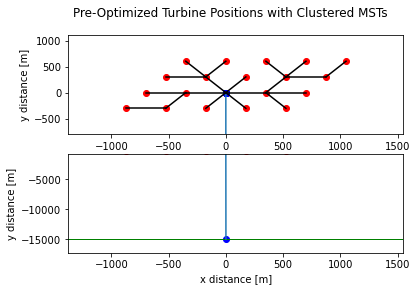

In [227]:
#PLOTTING PRE-OPTIMISED MST

# the Boruvka_mod code requires graphs with vertices 0....n, which is provided by the index value on indices list.
# When this is plotted, the values within the correct indiceslist row are then used to reference the index within
# positionlist to be plotted.

#

MSTweight=Minimum_Spanning_Tree(geom_analysis(positionlist, indiceslist)[0],indiceslist)

fig, (ax1,ax2) = plt.subplots(2)
fig.suptitle('Pre-Optimized Turbine Positions with Clustered MSTs')

#Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)
ax1.scatter(positionlist[:,0],positionlist[:,1],c='red') # Prints turbine positions in red
ax1.scatter(OnshoreSubstation[0,0],OnshoreSubstation[0,1],c='blue') #onshore substation
ax1.plot(TXShoreLine,TYShoreLineSmooth,c='green',linewidth=1) #Produces line representing the shore line in green
ax1.plot([positionlist[0,0],OnshoreSubstation[0,0]],[positionlist[0,1],OnshoreSubstation[0,1]]) #Plots Shore to substation connection
ax1.set_xlabel('x distance [m]') # x axis label
ax1.set_ylabel('y distance [m]') # y axis label
ax1.set_xlim([min(positionlist[:,0])-500, max(positionlist[:,0])+500]) #x limits
ax1.set_ylim([min(positionlist[:,1])-500, max(positionlist[:,1])+500]) #y limits 

#Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
ax2.scatter(positionlist[:,0],positionlist[:,1],c='red') # Prints turbine positions in red
ax2.scatter(OnshoreSubstation[0,0],OnshoreSubstation[0,1],c='blue') #onshore substation
ax2.plot(TXShoreLine,TYShoreLineSmooth,c='green',linewidth=1) #Produces line representing the shore line in green
ax2.plot([positionlist[0,0],OnshoreSubstation[0,0]],[positionlist[0,1],OnshoreSubstation[0,1]]) #Plots Shore to substation connection
ax2.set_xlabel('x distance [m]') # x axis label
ax2.set_ylabel('y distance [m]') # y axis label
ax2.set_xlim([min(positionlist[:,0])-500, max(positionlist[:,0])+500]) #x limits
ax2.set_ylim([min(positionlist[:,1])-DistanceToShore-2000, min(positionlist[:,1])-500]) #y limits

links = [None] * math.ceil(nturb/maxnodespertree)
MSTWeightSum = 0 #MST weight is simply the total length of cabling used

for a in range(0,math.ceil(nturb/maxnodespertree)):
    MSTWeightSum += MSTweight[a][0]
    print('Each tree weight', 'tree',a+1 ,MSTweight[a][0])
    links[a] = MSTweight[a][1]
    
    for b in links[a]:
        u = positionlist[(indiceslist[a,b[0]])][0], positionlist[(indiceslist[a,b[1]])][0]
        v = positionlist[(indiceslist[a,b[0]])][1], positionlist[(indiceslist[a,b[1]])][1]
        ax1.plot(u,v, c='black')
        ax2.plot(u,v, c='black')
        ax1.scatter(positionlist[0,0],positionlist[0,1],c='blue')
        ax2.scatter(positionlist[0,0],positionlist[0,1],c='blue')

        
print('MST total weight', MSTWeightSum, 'm')

In [228]:
#DISPLAYS RAW BATHYMETRY DATA

print(data) # Prints out bathymetry data - Read in using pandas in previous section

      SURVEY_ID  TIMEZONE      DATE     TIME       LAT      LON  POS_TYPE  \
0        NSEA86         0  19860424  149.733  54.50260  4.42565       NaN   
1        NSEA86         0  19860424  150.700  54.50254  4.42011       NaN   
2        NSEA86         0  19860424  151.717  54.50247  4.41424       NaN   
3        NSEA86         0  19860424  152.683  54.50240  4.40861       NaN   
4        NSEA86         0  19860424  153.667  54.50234  4.40282       NaN   
...         ...       ...       ...      ...       ...      ...       ...   
18132    NSEA86         0  19860513  555.800  52.81589  4.07220       NaN   
18133    NSEA86         0  19860513  556.900  52.81516  4.07883       NaN   
18134    NSEA86         0  19860513  557.733  52.81459  4.08396       NaN   
18135    NSEA86         0  19860513  558.700  52.81396  4.08972       NaN   
18136    NSEA86         0  19860513  559.750  52.81325  4.09609       NaN   

       NAV_QUALCO  BAT_TTIME  CORR_DEPTH  ...  MAG_RESSEN  MAG_DICORR  \
0 

In [229]:
#CONVERTS LATITUDE AND LONGITUDE IN BATHYMETRY DATA TO CENTERED EASTINGS AND NORTHINGS

data['easting'] = data.apply(lambda row: utm.from_latlon(row['LAT'], row['LON'])[0], axis=1) #Converts lon/lat to easting and adds this onto the 'data' file
data['northing'] = data.apply(lambda row: utm.from_latlon(row['LAT'], row['LON'])[1], axis=1) #Converts lon/lat to northing and adds this onto the 'data' file

zero_east = min(data['easting']) + (max(data['easting']) - min(data['easting']))/2 +30000 # Determines centre of bathymrtry data in easting direction (+30,000 is simply to get a more interesting result from the current bathymetry data)
zero_north = min(data['northing']) + (max(data['northing']) - min(data['northing']))/2 # Determines centre of bathymetry data in northing direction   

data['centered_easting'] = data['easting'] - zero_east # Centres the data about (0,0) and adds this onto the 'data' file
data['centered_northing'] = data['northing'] - zero_north # Centres the data about (0,0) and adds this onto the 'data' file

print(data) 

      SURVEY_ID  TIMEZONE      DATE     TIME       LAT      LON  POS_TYPE  \
0        NSEA86         0  19860424  149.733  54.50260  4.42565       NaN   
1        NSEA86         0  19860424  150.700  54.50254  4.42011       NaN   
2        NSEA86         0  19860424  151.717  54.50247  4.41424       NaN   
3        NSEA86         0  19860424  152.683  54.50240  4.40861       NaN   
4        NSEA86         0  19860424  153.667  54.50234  4.40282       NaN   
...         ...       ...       ...      ...       ...      ...       ...   
18132    NSEA86         0  19860513  555.800  52.81589  4.07220       NaN   
18133    NSEA86         0  19860513  556.900  52.81516  4.07883       NaN   
18134    NSEA86         0  19860513  557.733  52.81459  4.08396       NaN   
18135    NSEA86         0  19860513  558.700  52.81396  4.08972       NaN   
18136    NSEA86         0  19860513  559.750  52.81325  4.09609       NaN   

       NAV_QUALCO  BAT_TTIME  CORR_DEPTH  ...   GRA_OBS  EOTVOS  FREEAIR  \

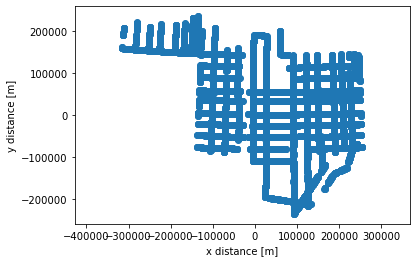

In [230]:
#PLOTS CENTERED BATHYMETRY DATA

fig, ax = plt.subplots()
plt.axis('equal')
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
ax.scatter(data['centered_easting'],data['centered_northing'])
plt.show()

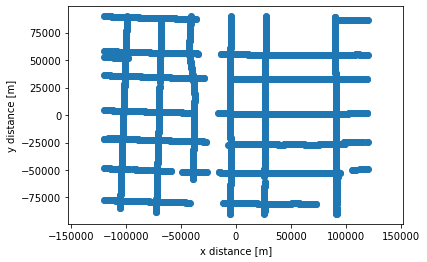

In [231]:
# SAMPLING AND PLOTTING CENTRAL BATHYMETRY DATA
# Takes sample between +/-120000 in easting direction, +/-90000 in the northing direction, and +/-1000 for the depth values

fig, ax = plt.subplots()
plt.axis('equal')
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
data = data[(data['centered_easting'] >=-120000) & (data['centered_easting'] <= 120000) & (data['centered_northing']>=-90000) & (data['centered_northing']<= 90000) & (data['CORR_DEPTH']<=1000) & (data['CORR_DEPTH']>=-1000)]
ax.scatter(data['centered_easting'],data['centered_northing'])
plt.show()

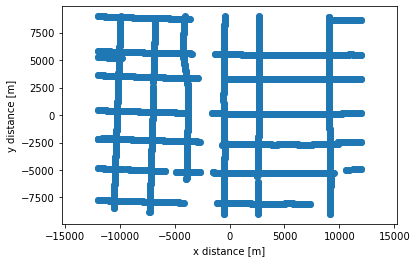

In [232]:
#FURTHER BATHYMETRY DATA PROCESSING
#Further decreases the area considered to be more applicable to the size of the wind farm (Sample from before divided by 10 in northing and easting directions)

fig, ax = plt.subplots()
plt.axis('equal')
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
data['centered_easting'] = data['centered_easting']/10
data['centered_northing'] = data['centered_northing']/10
ax.scatter(data['centered_easting'],data['centered_northing'])
plt.show()

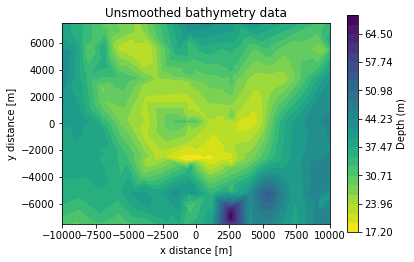

In [233]:
#UNSMOOTHED BATHYMETRY DATA CONTOUR PLOTTING

fig, ax = plt.subplots()
plt.xlim([-10000, 10000]) # x Limits of plot between +/-10000
plt.ylim([-7500, 7500]) # y Limits of plot between +/-7500
ax.set_aspect(aspect=1) # Sets the aspect of the axis scaling, i.e. the ratio of y-unit to x-unit.
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')

maxdepth = max(data['CORR_DEPTH'])
levels = np.linspace(mindepth,maxdepth,24) # Creates 24 even spaces or levels between the min and max depth

tcf = ax.tricontourf(data['centered_easting'], data['centered_northing'], data['CORR_DEPTH'], levels=levels, cmap = 'viridis_r') # (x,y,colour bar factor,level values,colour scale)
cbar = plt.colorbar(tcf)
cbar.set_label('Depth (m)')
ax.set_title('Unsmoothed bathymetry data');

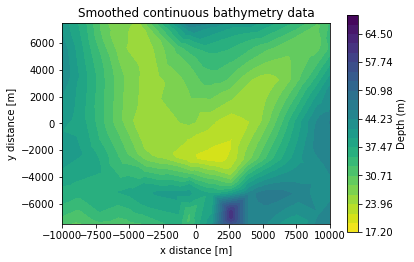

In [234]:
#SMOOTHING BATHYMETRY DATA

smooth = spline.SmoothBivariateSpline(data['centered_easting'], data['centered_northing'], data['CORR_DEPTH'], s = 25000)

fig, ax = plt.subplots()
plt.xlim([-10000, 10000])
plt.ylim([-7500, 7500])
ax.set_aspect(aspect=1)
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
levels = np.linspace(mindepth,maxdepth,24)

tcf = ax.tricontourf(data['centered_easting'], data['centered_northing'], smooth(data['centered_easting'], data['centered_northing'], grid=False), levels=levels, cmap = 'viridis_r')
cbar = plt.colorbar(tcf)
cbar.set_label('Depth (m)')
ax.set_title('Smoothed continuous bathymetry data');

In [235]:
# DETERMINING DEPTH AND ASSOCIATED COST FOR EACH TURBINE

def depthvalues(positionlist):
    DepthPerTurbine = [None] * (len(positionlist)-1) # none defines a null/no value. Get a null list the size of the np. turbines
    DepthCostPerTurbine = [None] * (len(positionlist)-1) # Get a null list the size of the number of turbines
    DepthCostAllTurbines = 0 # Assigns initial value to variable

    for i in range(0,len(positionlist)-1): # loops for amount of turbines
        DepthPerTurbine[i] = spline.SmoothBivariateSpline.ev(smooth, positionlist[i+1,0], positionlist[i+1,1]) # Acquires depth assigned to each turbines position (x,y)
        DepthCostPerTurbine[i] = MinDepthCostPerTurbine = CostperTurbine*(0.0002*(float(DepthPerTurbine[i])**2) - 0.0002*(float(DepthPerTurbine[i])) + 0.9459)-CostperTurbine #Formula for depth cost
        DepthCostAllTurbines += DepthCostPerTurbine[i] # Sums up all turbines depth costs
        
    mindepth=float(min(DepthPerTurbine))
    maxdepth=float(max(DepthPerTurbine))
    return DepthCostAllTurbines, mindepth, maxdepth # returns respective values to user

depthvalues(positionlist)

(3166157.101526773, 24.435653877898705, 27.064755136536917)

In [236]:
#SETTING MODEL PARAMETERS

v0=8.0  #Incoming wind speed
nwind = 33
wind=np.arange(254,287)

#b=np.array((1,5,1000))
#b=np.array(( 1.40002561e-01,   8.51478121e+00,   2.62606729e+03))

# 3 model parameters below:

# 0th: how much power the turbine removes at the centre of the peak of the power distribution.
# 1st: how wide the angle of effect is. UNITS: degrees
# 2nd: up to how far back the effect takes place (approx. 2.6km) UNITS: [m]

model=np.array((1.39998719e-01, 8.51483871e+00, 2.62613638e+03))

ws=2.0 #weibull scale factor
wei_gamma=gamma(1.+1./ws)

Pr = 2*10**6 #Rated Power for Horns Rev 1 Turbines. Max power output [Watts]
Vc = 4.0 #Cut-in Velocity. Starts producing energy at wind speed of 4m/s [m/s]
Vr = 15.0 #Rated Velocity. Starts producing max energy at 15m/s
Vf = 25.0 #Cut-off Velocity. Turbines cut out at wind speeds of 25m/s to prevent damage to the turbines.
k = 2.0 #Weibull shape parameter
(Pr,Vc,Vr,k)

#interpolation parameters
dvel=1.5 #[m/s]
dang=5. #[degrees]

In [237]:
#DETERMINING WIND DIRECTION AND VELOCITY AT HORNS REV 1

v=np.loadtxt('hornsrev_data_all.txt') # assigns data to variable v.
vxref=v[:,3] # (INDEXING STARTS FROM 0). Third column of data is velocity of wind in x direction.
vyref=v[:,4] # (INDEXING STARTS FROM 0). Fourth column of data is velocity of wind in y direction.
angles=v[:,0] # Zeroth column of data is wind angle.
vmean=np.sqrt(np.square(vxref)+np.square(vyref)) # Uses pythagoras to find the wind magnitude + direction for each location.

vmean=pd.DataFrame(vmean) # organises vmean into labelled data structure
vref=pd.DataFrame()

vmean['angle']=angles # add another column to vmean (angle)
vref=vref.append(vmean) # add empty pandas data frame

vref=vref.groupby('angle')
vref.groups
vref.describe()
vref.get_group(260).iat[50,0] # data manipulation to group by angle etc.

6.512913707119303

In [238]:
#Arrays for pairwise distances and angles
#Angle 0: x direction. Angle pi/2: y directıon

# calculates distance and angle between each pair of turbines:

distance=np.zeros((nturb,nturb)) # 2x2 matrix of distances between turbines i and j where distance i-i and distance j-j = 0
# as they're distances to themselves: i-i i-j
                                 #    j-i j-j

angle=np.zeros((nturb,nturb)) # same as above but for angles between turbines.

for i in range(0,nturb):
   
    # 80x80 matrices as there's 80 turbines at Horns Rev 1.
    # squares y distance and x distance then sqrt to find overall distance between 2 turbines.
    distance[i,:]=np.sqrt(np.square(positionlist[i+1,0]-positionlist[1:,0])+np.square(positionlist[i+1,1]-positionlist[1:,1]))
    # same as above using arctan2 whilst giving correct quadrant (between 2 turbines).
    angle[i,:]=np.arctan2(positionlist[1:,1]-positionlist[i+1,1],positionlist[1:,0]-positionlist[i+1,0])
# Rotate angles so that north=0 and convert to degrees (and clockwise instead of anticlockwise)
angle=-np.rad2deg(angle)+270

# Rotating angles to wind direction
windangle=5 # degrees
rotangles=np.mod(angle-windangle+180,360)-180

In [239]:
# IMPORTING WIND DIRECTION DATA

#meteorological data where north = 0 degrees)
directiondata = pd.read_csv ('Directiondata.csv')
print (directiondata)
# velocity is the mean velocity with which wind from this direction blows
# c determines how wide the distribution is
# frequency/100 determines how often the wind is blowing at this angle

    Angle  Velocity     c  frequency
0       0      8.89  2.09       4.82
1      30      9.27  2.13       4.06
2      60      8.23  2.29       3.59
3      90      9.78  2.30       5.27
4     120     11.64  2.67       9.12
5     150     11.03  2.45       6.97
6     180     11.50  2.51       9.17
7     210     11.92  2.40      11.84
8     240     11.49  2.35      12.41
9     270     11.08  2.27      11.34
10    300     11.34  2.24      11.70
11    330     10.79  2.19       9.69
12    360      8.89  2.09       4.82


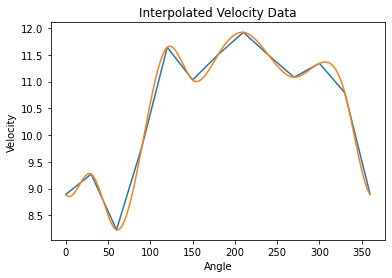

In [240]:
# interpolate 'velocity'
# info is only given every 30 degrees, giving a 'step function'
# interpolation gives higher resolution
# function is periodic as 360deg is the same as 0deg.
x = directiondata['Angle']
y = directiondata['Velocity']
wbvel = SP (x, y,bc_type='periodic')
xs = np.arange(0, 360,0.10)
plt.plot(x,y, label='Line')
plt.plot(xs, wbvel(xs), label="Interpolated line ")
plt.title('Interpolated Velocity Data')
plt.xlabel('Angle')
plt.ylabel('Velocity')
plt.show()
# blue lines shows linear interpolation, orange shows smooth interpolation including across the
# periodic boundary.

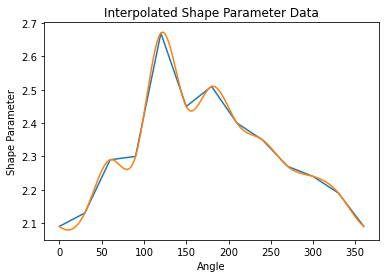

In [241]:
#interpolate 'c'
# info is only given every 30 degrees, giving a 'step function'
# interpolation gives higher resolution
# function is periodic as 360deg is the same as 0deg.
x = directiondata['Angle']
y = directiondata['c']
wbshape = SP (x, y,bc_type='periodic')
xs = np.arange(0, 360, 0.1)
plt.plot(x,y)
plt.plot(xs, wbshape(xs), label="S")
plt.title('Interpolated Shape Parameter Data')
plt.xlabel('Angle')
plt.ylabel('Shape Parameter')
plt.show()

0       0
1      30
2      60
3      90
4     120
5     150
6     180
7     210
8     240
9     270
10    300
11    330
12    360
Name: Angle, dtype: int64
0     0.001607
1     0.001353
2     0.001197
3     0.001757
4     0.003040
5     0.002323
6     0.003057
7     0.003947
8     0.004137
9     0.003780
10    0.003900
11    0.003230
12    0.001607
Name: frequency, dtype: float64


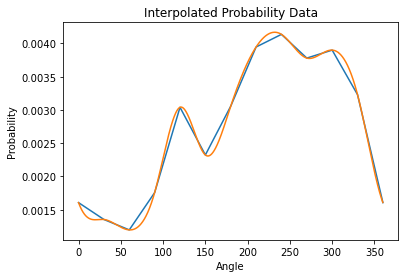

In [242]:
#interpolate 'frequency'
# info is only given every 30 degrees, giving a 'step function'
# interpolation gives higher resolution
# function is periodic as 360deg is the same as 0deg.
x = directiondata['Angle']
y = directiondata['frequency']/(100.*30.) #Data is in percent per 30 degrees, changing to probability per degree
print(x)
print(y)

windfreq = SP (x, y,bc_type='periodic')
xs = np.arange(0, 360, 0.1)
plt.plot(x,y)
plt.plot(xs, windfreq(xs), label="S")
plt.title('Interpolated Probability Data')
plt.xlabel('Angle')
plt.ylabel('Probability')
plt.show()
# plot shows wind direction is predominantly 200-320deg.

In [243]:
# Simple Attenuation fn
# Determines how much wind there is AFTER a turbine.
def att(dist, ang, model): 
        # 'Model' parameters are defined in 2ND CELL.

    # angular part
    angular=np.where(2.*model[1]*np.abs(ang)<np.pi,np.square(np.cos(model[1]*ang)),0.)
    # angular = np.cos(model[1]*ang WHEN 2.*model[1]*np.abs(ang) is less than pi, else angular = 0.
    
    # radial part (distance) (Gaussian Function)
    radial=np.exp(-np.square(dist/model[2])) # decreasing exponential of square, scaled by 2nd parameter
    penalty=np.exp(-np.square(dist/200))
    #penalty = 0
    return 1.0-1*model[0]*angular*radial-2*model[0]*penalty # OUTCOME

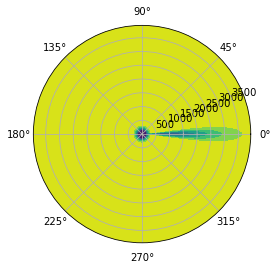

0.580003843


In [244]:
azimuths = np.radians(np.linspace(0, 360, 360)) # angles theta from 0 to 360 degress in 1 degree increments. Grid
zeniths = np.arange(0, 4000, 50) # distance from 0 to 4000 broken up into increments of 50.

r, theta = np.meshgrid(zeniths, azimuths)
values = att(r,np.mod(theta+np.pi,np.pi*2)-np.pi,model) # gets angles from -pi to pi, not from 0 to 2pi.

fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
ax.contourf(theta, r, np.maximum(values,0.85*np.ones(np.shape(values))))

plt.show()
print(np.min(values))

## Cell description:
# Polar plot is for 1 turbine, blue area shows where wind speed is affected. (Numbers label distance from turbine).
# Across the curve the distribution is the hump of cosine^2 function.
# Radially the distribution shown is Gaussian.
# Wake is currently too narrow close to the turbine as it treats the turbine as a point rather than accommodating
# for the blades' diameter.

In [245]:
# # isn't useful for continuing code, just rotates the windfarm.
# def rotate(angle,coords):
#     angle = np.pi*angle/180.
#     rotcoordx = []
#     rotcoordy = []
#     for coord in coords:
#         rotcoordx+=[coord[0]*np.cos(angle)-coord[1]*np.sin(angle)]
#         rotcoordy+=[coord[0]*np.sin(angle)+coord[1]*np.cos(angle)]
#     rotcoords=[rotcoordx,rotcoordy]
#     rotcoords=np.array(rotcoords).T   
#     return rotcoords 
# #print rotate(254,coords)[:,0]
# plt.scatter(rotate(0,coords)[:,0],rotate(0,coords)[:,1])

In [246]:
# returning total deviation between model and training set (between CFD data and the attenuation model)
# This was relevant for earlier stages of the project when the wake model was being developed
#Total att
def deviation(b):
    total_att=np.ones((nturb,nwind))
    deviation=0
    for k in range(0,nwind):
        for j in range(0,nturb):
            for i in range(0,nturb):
                if (i!=j):
                    total_att[j,k] = total_att[j,k]*att(distance[i,j],np.mod(np.deg2rad(angle[i,j]-wind[k])+np.pi,np.pi*2)-np.pi,b)
 #           print('{0} {1} {2}'.format(j,wind[k],total_att[j,k]))
            deviation=deviation+np.square(vref.get_group(wind[k]).iat[j,0]-v0*total_att[j,k])
    return deviation

In [247]:
# returning deviation for each turbine.
# This was relevant for earlier stages of the project when the wake model was being developed
#Total att
def deviation_sq(model):
    total_att=np.ones((nturb,nwind))
    dev_vec=np.zeros((nturb*nwind))
    for k in range(0,nwind):
        for j in range(0,nturb):
            for i in range(0,nturb):
                if (i!=j):
                    total_att[j,k] = total_att[j,k]* att(distance[i,j],np.mod(np.deg2rad(angle[i,j]-wind[k])+np.pi,np.pi*2)-np.pi,model)
 #           print('{0} {1} {2}'.format(j,wind[k],total_att[j,k]))
            dev_vec[nturb*k+j]=(vref.get_group(wind[k]).iat[j,0]-v0*total_att[j,k])
    return dev_vec

In [248]:
# USEFUL OUTPUT USED IN TARGET FN
# Calculates the % of wind that arrives at a turbine for a certain angle.
# Starts with assumption that there's zero wake so all turbines get full wind.
#talked about
#Total att
def windspeedreduction(distance,angle,direction,model): # vectors
    ndir=np.size(direction)
    total_att=np.ones((nturb,ndir)) # as many rows as there are turbines, as many columns as there are wind directions.
 #   power_vec=np.zeros((nturb,ndir))
    for j in range(0,nturb):
        for i in range(0,nturb):
            if (i!=j):
                # compounding wind speed reductions
                total_att[j,:] = total_att[j,:]* att(distance[i,j],np.mod(np.deg2rad(angle[i,j]-direction[:])+np.pi,np.pi*2)-np.pi,model)
  #      power_vec[j,:]=(v0*total_att[j,:])**3
    return total_att # matrix output that's needed. nturb turbine rows, ndir direction columns.
                     # Tells how much of 100% of wind arrives at a certain turbine from a certain direction.

In [249]:
# USEFUL OUTPUT USED IN TARGET FN
# Calculates the power produced by turbines when it sees a certain wind speed at a certain angle. 3D matrix
def power(wsr,v): # wind speed reduction, velocity
    nvel=np.size(v)
    nangle=np.size(wsr,1)
    power_vec=np.zeros((nturb,nangle,nvel))
    power_vec=POvec(np.outer(wsr,v)).reshape(nturb,nangle,nvel) # np.outer takes every wsr element and individually multiplies it with every element of v.
    return power_vec

In [250]:
#GIVES PROBABILITY OF WIND SPEED V AT A GIVEN ANGLE
def windspeedprobability(angles,v,d_angle,d_vel):
    nvel=np.size(v) 
    nangle=np.size(angles)
    wsprob=np.zeros((nangle,nvel))
    for i in range(angles.shape[0]):
        # Get Weibull parameters for angle and evaluate probability
        wsprob[i,:]=(wei(v[:],wbvel(angles[i]),wbshape(angles[i])))*windfreq(angles[i])*d_angle*d_vel
    return wsprob

In [251]:
# DEFINES WEIBULL DISTRIBUTION (shows the probability of any given wind speed occuring).

def wei(x,n,k): # convention to have in this order, scale parameter comes first (x) 
    u=n/gamma(1+1/k) #scaled wind speed
    return (k / u) * (x / u)**(k - 1) * np.exp(-(x / u)**k)
# k = Weibull shape parameter
# n = scale parameter
# x= value we are valuating

In [252]:
def wind_dist(v,vm):
    return wei(v,vm,k)

In [253]:
wind_dist(1.0,v0)

0.024244336764100854

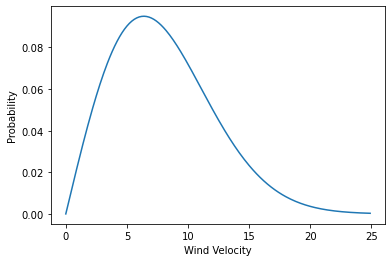

In [254]:
# PLOTS WEIBULL DISTRIBUTION

x=np.arange(0,25,0.1)
y=wind_dist(x,v0)

plt.xlabel('Wind Velocity')
plt.ylabel('Probability')
plt.plot(x,y)

In [255]:
 velocities=np.arange(Vc,Vf,dvel) # 1D array ranging from Vc to Vf in dvel intervals. 4 to 25 in steps of 1.5
angles=np.arange(0,360,dang) # 0 to 360 with intervals of dang.
wsp=windspeedprobability(angles,velocities,dang,dvel) # tells probability of getting wind from a certain direction with a certain velocity.
# sum of all numbers would add up to 1.
print(wsp,np.shape(wsp),np.sum(wsp)) # wsp array, shape of wsp (rows,columns), sum of wsp elements
print(np.shape(velocities)) # shape of velocities array (rows, columns)
#plt.plot(x,y)

[[7.95303494e-04 9.80036676e-04 1.05789271e-03 ... 6.39190809e-05
  3.40253887e-05 1.70630457e-05]
 [7.34767202e-04 9.01764403e-04 9.69915308e-04 ... 5.75583274e-05
  3.06371248e-05 1.53701909e-05]
 [6.87320078e-04 8.44491359e-04 9.10294073e-04 ... 5.77144043e-05
  3.11157981e-05 1.58295009e-05]
 ...
 [9.80182139e-04 1.25683306e-03 1.41621103e-03 ... 1.55577912e-04
  9.05953796e-05 4.99151675e-05]
 [9.27369324e-04 1.17045619e-03 1.29626789e-03 ... 1.10756647e-04
  6.20462178e-05 3.28196113e-05]
 [8.63068120e-04 1.07416013e-03 1.17166708e-03 ... 8.08008629e-05
  4.38237311e-05 2.24068824e-05]] (72, 14) 0.9458659589195532
(14,)


In [256]:
# CALCULATES THE POWER CURVE OF A TURBINE

# Plots the power curve of a turbine.
# No power output from 0-4m/s, then cubic rise up to 15m/s and stays
# constant until cut-off velocity of 25m/s.

#cubic Based Power output
a=Pr/(Vr**3-Vc**3)
b=Vc**3/(Vr**3-Vc**3)

def q(v): # q is power output

    if (v<Vc): # below cut in velocity power is 0.
        q=0
    elif (v<Vr):
        q=a*v**3-b*Pr # cubic power output between cut in and max.
    elif (v<Vf):
        q=Pr # max power between max and cut off velocity.
    else: 
        q=0 # no power above cut off velocity.
    return q

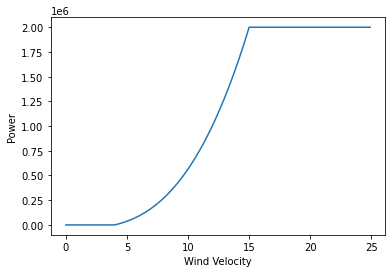

In [257]:
#PLOTS TURBINE POWER CURVE

x=np.arange(0,25,0.1)
POvec=np.vectorize(q) # vectorises power output function q (from cell above).
y=POvec(x)

plt.xlabel('Wind Velocity')
plt.ylabel('Power')
plt.plot(x,y)

In [258]:
wsr=windspeedreduction(distance,angle,angles,model)
powout=power(wsr,velocities)

In [259]:
# EXPECTED TURBINE OUTPUT (Watts) for the given wind distribution and positions.
# Can be seen that top left (NW) produces most energy for Horns Rev 1 Wind Farm.

# EXPECTED POWER FROM WIND FARM CALCULATIONS
# multiply the power that you'd get for each wind angle and speed condition by the probability of this occuring, for all angles and speed
# values and sum to find the expected power.
# Sum up this value for all turbines to find total wind farm expected power output.
output=np.zeros((nturb)) 
output=np.tensordot(powout,wsp,2)
print(output,np.shape(output),np.sum(output))
# last output is total power output in Watts.

[668379.55316091 633498.97180621 662521.26719996 673338.49753347
 697664.64143336 744237.99689106 742710.39198905 727984.04558742
 715292.41103342 674925.54106258 666368.75034877 704131.92411862
 664953.969405   666955.06338719 676936.75144094 708780.81514133
 713202.62794748 733984.75225679 795757.96078906] (19,) 13271625.932532629


In [260]:
# TURBINE OUTPUT (Watts) WITH NO INTERFERENCE

#Reference output:
# Same calculations as cell above except each turbine sees the full amount of wind every time
# (i.e. no wind reduction from other turbines).
refpowout=power(np.ones((nturb,np.size(angles))),velocities)
refoutput=np.zeros((nturb))
refoutput=np.tensordot(refpowout,wsp,axes=2)
print(refoutput,np.shape(refoutput),np.sum(refoutput))

# last output is total power output in Watts.

[867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078] (19,) 16476052.541534858


In [261]:
# # assigns smaller interpolation intervals to dvel and dang to compare to coarser interpolations.
# dvel=0.1
# dang=0.1
# velocities=np.arange(Vc,Vf+dvel,dvel)
# angles=np.arange(0,360,dang)
# wsp=windspeedprobability(angles,velocities,dang,dvel)
# wsr=windspeedreduction(distance,angle,angles,model)
# powout=power(wsr,velocities)
# output=np.zeros((nturb)) 
# output=np.tensordot(powout,wsp,2)
# print (dvel,dang,np.sum(output))
# fineout=output

In [262]:
# # Calculates RMS error from changing interpolation value.
# velarray=np.array([1.5])
# angarray=np.array([5])
# rmserror=np.zeros((np.size(velarray),np.size(angarray)))
# i=0
# for dvel in velarray:
#     j=0
#     for dang in angarray:
#         velocities=np.arange(Vc,Vf+dvel,dvel)
#         angles=np.arange(0,360,dang)
#         wsp=windspeedprobability(angles,velocities,dang,dvel)
#         wsr=windspeedreduction(distance,angle,angles,model)
#         powout=power(wsr,velocities)
#         output=np.zeros((nturb)) 
#         output=np.tensordot(powout,wsp,2)
#         rmserror[i,j]=np.sqrt(np.sum(np.square(output-fineout))/np.size(output))
#         print (dvel,dang,np.sum(output),rmserror[i,j])
#         j+=1
#     i+=1
# print(rmserror)

In [1]:
distance,angle,distance_global, angle_global = geom_analysis(positionlist,indiceslist)
wsr=windspeedreduction(distance_global,angle_global,angles,model)
powout=power(wsr,velocities) # total output power
output=np.tensordot(powout,wsp,axes=2)

NameError: name 'geom_analysis' is not defined

In [264]:
# Function for calculated payback time, discounted payback time, Net Present Value, and Profitability Index

def Payback(TPO,TotalCost):
    
    CashFlowYearly = ElectricityCostperkWh*24*365*(TPO/1000) # Calculates the yaerly income for the windfarm
    PayBackTime = TotalCost/CashFlowYearly # calculates payback time in years
    DiscountedPayBackTime = (np.log(1/(1-((TotalCost*DiscountRate)/CashFlowYearly))))/np.log(1+DiscountRate) #Calculates payback time but takes into account the time value of money
    
    l=0
    NPV = 0
    
    for l in range(LifeTimeTurbineOperatingTime):
        l+=1
        NPV = NPV + (CashFlowYearly)/((1+DiscountRate)**l) #NPV is a method used to determine the current value of a;; future cash flows generated by the project
    
    NPV = NPV - TotalCost
    ProfIndex = (NPV+TotalCost)/TotalCost # Probability index >1 it's profitable <1 its not
    
    return PayBackTime,DiscountedPayBackTime,NPV,ProfIndex

In [265]:
#PLOTTING FUNCTION

def plotting_function(positionlist,indiceslist,MSTweight,data,ExportCableCost):

    mindepth = min(data['CORR_DEPTH'])
    maxdepth = max(data['CORR_DEPTH'])

    nturb=np.size(positionlist,0)-1 # -1 due to the substation ar positonlist[0,:]
    links = [None] * math.ceil(nturb/maxnodespertree) # math.ceil rounds a number upwards to its nearest integer
    MSTWeightSum = 0

    fig, (ax1,ax2) = plt.subplots(2)
    fig.suptitle('Plot Showing Sea Floor Topography and Turbines with Cables')
    
    #Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)
    ax1.set_xlabel('x distance [m]') # x axis label
    ax1.set_ylabel('y distance [m]') # y axis label
    ax1.set_xlim([min(positionlist[:,0])-500, max(positionlist[:,0])+500]) #x limits
    ax1.set_ylim([min(positionlist[:,1])-500, max(positionlist[:,1])+500]) #y limits 
    
    #Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
    ax2.set_xlabel('x distance [m]') # x axis label
    ax2.set_ylabel('y distance [m]') # y axis label
    ax2.set_xlim([min(positionlist[:,0])-500, max(positionlist[:,0])+500]) #x limits
    ax2.set_ylim([min(positionlist[:,1])-DistanceToShore-2000, min(positionlist[:,1])-500]) #y limits
    
    for a in range(0,len(MSTweight)):
        MSTWeightSum += MSTweight[a][0]
        links[a] = MSTweight[a][1]
        for b in links[a]:
            u = positionlist[(indiceslist[a,b[0]])][0], positionlist[(indiceslist[a,b[1]])][0]
            v = positionlist[(indiceslist[a,b[0]])][1], positionlist[(indiceslist[a,b[1]])][1]
            ax1.plot(u,v, c='black')
            ax2.plot(u,v, c='black')
    
    FixedCost = (OffshoreSubstationCostperMW+OnshoreSubstationCostperMW)*nturb
    CableCost=(MSTWeightSum/1000)*IACableCostperMeter
    DepthCostAll = depthvalues(positionlist)[0]
    TurbineCostTotal =(nturb)*CostperTurbine
    MaintenanceCosts=(nturb)*MaintenanceCostperTurbine # 1563720 lifetime maintenace cost per MW (*2 cus 2MW turbines)
    LandCost = (max(positionlist[:,0])-min(positionlist[:,0])) * (max(positionlist[:,1])-min(positionlist[:,1])) * (LandCostpermSquared)
    TotalCost=TurbineCostTotal+DepthCostAll+MaintenanceCosts+FixedCost+LandCost+CableCost+ExportCableCost 
    
    print('\033[1m'+'Maximum turbines per MST:'+'\033[0m', maximumturbinespertree)
    print('\033[1m'+'Number of turbines:'+'\033[0m', nturb)
    print()
    print('\033[1m'+'Inter-Array Cabling Costs: £'+'\033[0m', CableCost)
    print('\033[1m'+'Export Cabling Costs: £'+'\033[0m', ExportCableCost)
    print('\033[1m'+'Depth Cost: £'+'\033[0m', DepthCostAll)
    print('\033[1m'+'Turbine Cost: £'+'\033[0m', TurbineCostTotal)
    print('\033[1m'+'Land Cost: £'+'\033[0m', LandCost)
    print('\033[1m'+'Maintenance Cost: £'+'\033[0m', MaintenanceCosts)
    print('\033[1m'+'Fixed Cost:'+'\033[0m', FixedCost)
    print()
    print('\033[1m'+'Budget: £'+'\033[0m', budget)
    print('\033[1m'+'Total Cost: £'+'\033[0m', TotalCost)
        
    levels = np.linspace(mindepth,maxdepth,24) # Change to min(smooth) and max(smooth) somehow
    
    fig.subplots_adjust(left=0.1, right=0.8) #Adjusts plots to be able to fit a single color bar across both plots
    
    #Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)
    tcf = ax1.tricontourf(data['centered_easting'], data['centered_northing'], smooth(data['centered_easting'], data['centered_northing'], grid=False), levels=levels, cmap = 'viridis_r')
    cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8]) #Locates colorbar across both subplots
    cbar = plt.colorbar(tcf,cax=cb_ax) #plots colorbar with location as stated by cb_ax
    cbar.set_label('Depth (m)')    
    
    ax1.scatter(positionlist[:,0],positionlist[:,1],c='red') # Prints turbine positions in red
    ax1.scatter(positionlist[0,0],positionlist[0,1],c='blue') # offshore Substation
    ax1.scatter(OnshoreSubstation[0,0],OnshoreSubstation[0,1],c='blue') #onshore substation
    ax1.plot(TXShoreLine,TYShoreLineSmooth,c='green',linewidth=1) #Produces line representing the shore line in green
    ax1.plot([positionlist[0,0],OnshoreSubstation[0,0]],[positionlist[0,1],OnshoreSubstation[0,1]]) #Plots Shore to substation connection
    
    #Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
    tcf = ax2.tricontourf(data['centered_easting'], data['centered_northing'], smooth(data['centered_easting'], data['centered_northing'], grid=False), levels=levels, cmap = 'viridis_r')

    
    ax2.scatter(positionlist[:,0],positionlist[:,1],c='red') # Prints turbine positions in red
    ax2.scatter(positionlist[0,0],positionlist[0,1],c='blue') # offshore Substation
    ax2.scatter(OnshoreSubstation[0,0],OnshoreSubstation[0,1],c='blue') #onshore substation
    ax2.plot(TXShoreLine,TYShoreLineSmooth,c='green',linewidth=1) #Produces line representing the shore line in green
    ax2.plot([positionlist[0,0],OnshoreSubstation[0,0]],[positionlist[0,1],OnshoreSubstation[0,1]]) #Plots Shore to substation connection
    
    fig, ax3 = plt.subplots()
    PieChartLabels = ['(Inter-Array) Cabling Costs', 'Depth Costs', 'Turbine Costs', 'Land Costs', '(Life time) Maintenance Costs', 'Fixed Costs', '(Export) Cabling Costs'] # Titles for each segment of pie chart
    sizes = [CableCost,DepthCostAll,TurbineCostTotal,LandCost,MaintenanceCosts,FixedCost,ExportCableCost] # Figures for each segment of pie chart
    
    ax3.pie(sizes, labels=PieChartLabels, autopct='%1.1f%%') # Pie chart with brekadown of all associated costs
    ax3.axis('equal') #equal aspect ratio
    ax3.set_title('Wind Farm Costs') #Pie chart title
                                                                                                  
    return TotalCost

PRE-OPTIMISED LAYOUT INFORMATION

Maximum turbines per MST: 10
Number of turbines: 19

Inter-Array Cabling Costs: £ 6650000.0
Export Cabling Costs: £ 37500000.06032893
Depth Cost: £ 3166157.101526773
Turbine Cost: £ 42190969.65210954
Land Cost: £ 3018657.6598400865
Maintenance Cost: £ 24890000
Fixed Cost: 3053571.4285714286

Budget: £ 100000000
Total Cost: £ 120469355.90237677
Total Power Output: 13271625.932532629 W
Cost per Watt: 9.077211527418898 £/W

Payback Time: 7.195912233177084 years
Discounted Payback Time: 10.354960257547244 years
NPV: £ 56888848.48117691 over a  20 year period
Profitability Index: £ 1.47222671736767 over a  20 year period


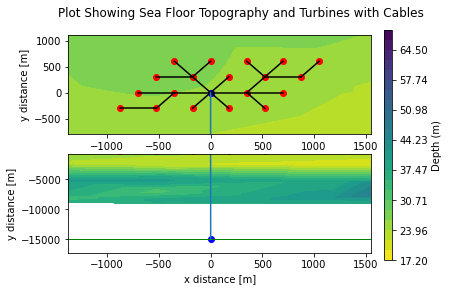

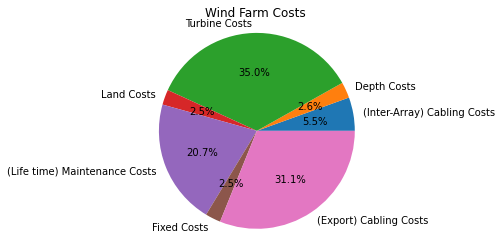

In [266]:
#DISPLAYING PRE-OPTIMISED LAYOUT AND ASSOCIATED INFO

print('\033[1m'+'\033[4m'+'PRE-OPTIMISED LAYOUT INFORMATION'+'\033[0m'+'\033[0m')
print()
MSTweight = Minimum_Spanning_Tree(distance,indiceslist)
TotalCost = plotting_function(positionlist,indiceslist,MSTweight,data,ExportCableCost)
TPO = np.sum(output)

PayBackTime,DiscountedPayBackTime,NPV,ProfIndex = Payback(TPO,TotalCost)

print('\033[1m'+'Total Power Output:'+'\033[0m', TPO, 'W')
print('\033[1m'+'Cost per Watt:'+'\033[0m',TotalCost/TPO,'£/W')
print('')
print('\033[1m'+'Payback Time:'+'\033[0m',PayBackTime,'years')
print('\033[1m'+'Discounted Payback Time:'+'\033[0m',DiscountedPayBackTime,'years')
print('\033[1m'+'NPV: £'+'\033[0m',NPV,'over a ',LifeTimeTurbineOperatingTime,'year period')
print('\033[1m'+'Profitability Index: £'+'\033[0m',ProfIndex,'over a ',LifeTimeTurbineOperatingTime,'year period')

In [267]:
#REDUCING NO. OF TURBINES PRE-OPTIMISATION

overspend = TotalCost - budget
if overspend > 0:
    nturbstoremove = math.floor(overspend/(MinCostperTurbTot))
    ### It can be safely assumed that this many turbines at minimum can be removed.
    print('Number of removed turbines:', nturbstoremove)
    for amount in range(0,nturbstoremove):
        nturb = nturb - 1
        positionlist = np.delete(positionlist, len(positionlist)-1, 0)
    indiceslist,u_labels,label = clustering_algorithm(positionlist,nturb,maxnodespertree)
    print('new number of turbines:', nturb)

Number of removed turbines: 4
new number of turbines: 15


C:\Users\adamb\anaconda3\lib\site-packages\pulp\pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


In [268]:
#TARGET FUNCTION

# analyses the coordinates to collate the distances and angles between all of them
# calculates the minimum spanning tree length and adds the assumption of cabling costs,
# turbines costs, maintenance costs and fixed costs.

smallestindiceslist = []
smallestTotalCost = None
smallestCostPerWatt = 10000000000000.0
smallestpositionlist = []
smallestExportCableCost = None

def targetfunction(coord_flat):
    
    #Global variables are used instead of res.x as res.x only holds the coordinates, not the other associated parameters,
    #inc. the optimal clustering, which will not necessarily be the same if the clustering algorithm is run again as the
    #start position is random for clustering. Additionally, res.x only provides an approximate minimization, whereas
    #storing values as global variables and finding the minimum guarantees that the minimum value found is returned.
    
    global smallestindiceslist
    global smallestTotalCost
    global smallestCostPerWatt
    global smallestpositionlist
    global smallestExportCableCost

    positionlist = np.reshape(coord_flat,(-1,2))#np.concatenate((arr1,arr2),axis=0) #np.reshape(coord_flat,(-1,2))
    
    nturb=np.size(positionlist,0)-1 # determines number of turbines (-1 due to the substation)
    print('nturb', nturb)
    
    OnshoreSubstation,ExportCableCost = Substation_To_Shore_Connection(positionlist)

    indiceslist,u_labels,label = clustering_algorithm(positionlist,nturb,maxnodespertree) # calls clustering function
    distance,angle,distance_global,angle_global = geom_analysis(positionlist,indiceslist) # calls pre-MST function
    
    MSTweight=Minimum_Spanning_Tree(distance,indiceslist) # Calls MST function
    MSTWeightSum=0
    
    FixedCost = (OffshoreSubstationCostperMW+OnshoreSubstationCostperMW)*nturb
    CableCost=(MSTWeightSum/1000)*IACableCostperMeter
    DepthCostAll = depthvalues(positionlist)[0]
    TurbineCostTotal=(nturb)*CostperTurbine
    MaintenanceCosts=(nturb)*MaintenanceCostperTurbine
    LandCost = (max(positionlist[:,0])-min(positionlist[:,0])) * (max(positionlist[:,1])-min(positionlist[:,1])) * (LandCostpermSquared)
    TotalCost=TurbineCostTotal+DepthCostAll+MaintenanceCosts+FixedCost+LandCost+CableCost+ExportCableCost
    
    wsr=windspeedreduction(distance_global,angle_global,angles,model) # calls wake attenuation function
    powout=power(wsr,velocities) # total output power
    output=np.tensordot(powout,wsp,axes=2) # resuced power output due to wake effects
    
    print('Total power output in Watts', np.sum(output),'Total Cost in £', TotalCost, '£/W', (TotalCost/(np.sum(output))))###
    TPO = np.sum(output)
    CostperWatt = TotalCost/TPO
    
    if CostperWatt < smallestCostPerWatt:
        smallestCostPerWatt = CostperWatt
        smallestindiceslist = indiceslist
        smallestTotalCost = TotalCost
        smallestpositionlist = positionlist
        smallestExportCableCost = ExportCableCost
    print('smallest cost per watt',smallestCostPerWatt)
    
    return CostperWatt

In [269]:
# OPTIMIZATION

t1_start = perf_counter() # timer starts

while True:  
    
    flat_coords=positionlist.flatten() # turns 2D coords into single list of data without any more structure.
    dvel=1.5
    dang=5
    velocities=np.arange(Vc,Vf,dvel)
    angles=np.arange(0,360,dang)        
    
    b0 = (max(TYShoreLineSmooth)+TooCloseShore)
    # b = (Lower bound, Upper bound)
    b1 = (b0,300000) #bounds for y coordinates of substation
    b2 = (-3000,3000) #bounds for x coordinates
    b3 = (((max(TYShoreLineSmooth))+((TooCloseShore-2500))),300000) #bounds for y coordinates of turbines
    bnd0 = (b2,b1) #bounds for x,y coordinates of the substation
    bnd = (b2,b3) #bounds for x,y coordinates of each turbine 
    bnd1 = (bnd*(nturb)) #repeats bnd fro the amount of turbines 
    bnds = bnd0+bnd1 #Combines all bounds into a list for use in the optimization function
    
## COULD USE BASINHOPPING AND SET THE STEP SIZE

    res = minimize(targetfunction, flat_coords, method='L-BFGS-B', jac=False, hess=None, bounds=bnds, options={'disp': 2, 'eps': 50})
    # minimizes target function with initial guess flat_coords 
        
    if smallestTotalCost<=budget: #if under budget
        if not res.success:
            print(res.status, res.message) 
        break # Stops optimization when minimization stops being succesful
    else: # over budget then removes a turbine and resets approrate varaibles 
        nturb = nturb - 1 
        smallestindiceslist = []
        smallestTotalCost = None
        smallestCostPerWatt = 10000000000000.0
        smallestpositionlist = []
        smallestExportCableCost = None
        positionlist = np.delete(positionlist, len(positionlist)-1, 0) 

        # CANNOT USE CALLBACK as this only returns targetfunction output and not the other variables that are needed too.
        
t1_stop = perf_counter() # timer ends
totaltime = t1_stop - t1_start # total run time in seconds
print('Total function time:', totaltime)

nturb 15
Total power output in Watts 10837563.513168873 Total Cost in £ 97786178.50040051 £/W 9.022893234404503
smallest cost per watt 9.022893234404503
nturb 15
Total power output in Watts 10837563.513168873 Total Cost in £ 97786178.47268888 £/W 9.022893231847505
smallest cost per watt 9.022893231847505
nturb 15
Total power output in Watts 10837563.513168873 Total Cost in £ 97911178.5002001 £/W 9.034427192166104
smallest cost per watt 9.022893231847505
nturb 15
Total power output in Watts 10779857.77433672 Total Cost in £ 97784412.45558383 £/W 9.071029924752459
smallest cost per watt 9.022893231847505
nturb 15
Total power output in Watts 10798458.401994707 Total Cost in £ 97788475.63591164 £/W 9.055781112037993
smallest cost per watt 9.022893231847505
nturb 15
Total power output in Watts 10805702.27761536 Total Cost in £ 97784472.21739763 £/W 9.049339849013222
smallest cost per watt 9.022893231847505
nturb 15
Total power output in Watts 10804997.254129902 Total Cost in £ 97788501.8406

Total power output in Watts 10782695.572354108 Total Cost in £ 97788625.18016574 £/W 9.069033297284887
smallest cost per watt 8.994598226012151
nturb 15
Total power output in Watts 10871465.74517991 Total Cost in £ 97784382.09314957 £/W 8.994590461410809
smallest cost per watt 8.994590461410809
nturb 15
Total power output in Watts 10785543.969215218 Total Cost in £ 97788696.6701043 £/W 9.0666448488105
smallest cost per watt 8.994590461410809
nturb 15
Total power output in Watts 10875421.688948877 Total Cost in £ 97862903.2985873 £/W 8.99853873234463
smallest cost per watt 8.994590461410809
nturb 15
Total power output in Watts 10861307.459804766 Total Cost in £ 97924622.25927244 £/W 9.015914761797255
smallest cost per watt 8.994590461410809
nturb 15
Total power output in Watts 10812876.440971622 Total Cost in £ 97784593.09712932 £/W 9.043346942041131
smallest cost per watt 8.994590461410809
nturb 15
Total power output in Watts 10882464.230697978 Total Cost in £ 97924407.57713196 £/W 8.9

Total power output in Watts 11630500.700765878 Total Cost in £ 98749632.40582052 £/W 8.490574477100353
smallest cost per watt 8.485972114089224
nturb 15
Total power output in Watts 11641363.298060188 Total Cost in £ 98752106.5117465 £/W 8.482864419170017
smallest cost per watt 8.482864419170017
nturb 15
Total power output in Watts 11598926.092771778 Total Cost in £ 98647851.3613025 £/W 8.504912486922207
smallest cost per watt 8.482864419170017
nturb 15
Total power output in Watts 11619345.28034824 Total Cost in £ 98752238.46584937 £/W 8.498950335254149
smallest cost per watt 8.482864419170017
nturb 15
Total power output in Watts 11625584.24141607 Total Cost in £ 98749128.09051217 £/W 8.494121761099887
smallest cost per watt 8.482864419170017
nturb 15
Total power output in Watts 11602623.858828245 Total Cost in £ 98752502.10251272 £/W 8.511221539546296
smallest cost per watt 8.482864419170017
nturb 15
Total power output in Watts 11633344.309106573 Total Cost in £ 98748553.5716177 £/W 8.

Total power output in Watts 11811767.80459055 Total Cost in £ 99233927.1650446 £/W 8.401276490253908
smallest cost per watt 8.382715041127893
nturb 15
Total power output in Watts 11888297.36270343 Total Cost in £ 99129196.85909793 £/W 8.338384701756459
smallest cost per watt 8.338384701756459
nturb 15
Total power output in Watts 11888297.36270343 Total Cost in £ 99129196.83077918 £/W 8.338384699374389
smallest cost per watt 8.338384699374389
nturb 15
Total power output in Watts 11888297.36270343 Total Cost in £ 99254196.85888842 £/W 8.348899243576605
smallest cost per watt 8.338384699374389
nturb 15
Total power output in Watts 11888426.094363641 Total Cost in £ 99127410.50478472 £/W 8.338144151123712
smallest cost per watt 8.338144151123712
nturb 15
Total power output in Watts 11890394.248115616 Total Cost in £ 99131605.31780058 £/W 8.337116772516682
smallest cost per watt 8.337116772516682
nturb 15
Total power output in Watts 11888788.107679736 Total Cost in £ 99127416.01822908 £/W 8.

Total power output in Watts 11943796.668946544 Total Cost in £ 99078412.66928282 £/W 8.29538675309864
smallest cost per watt 8.290503093284002
nturb 15
Total power output in Watts 11940231.894658994 Total Cost in £ 99082659.47579727 £/W 8.298219025387446
smallest cost per watt 8.290503093284002
nturb 15
Total power output in Watts 11945555.422478683 Total Cost in £ 99213057.95791341 £/W 8.305436997196306
smallest cost per watt 8.290503093284002
nturb 15
Total power output in Watts 11943824.763199162 Total Cost in £ 99082703.78020611 £/W 8.295726515135739
smallest cost per watt 8.290503093284002
nturb 15
Total power output in Watts 11948097.357718553 Total Cost in £ 99078488.55005534 £/W 8.292407199548801
smallest cost per watt 8.290503093284002
nturb 15
Total power output in Watts 11946251.624404384 Total Cost in £ 99265769.10266756 £/W 8.309365332627234
smallest cost per watt 8.290503093284002
nturb 15
Total power output in Watts 11937942.585341148 Total Cost in £ 99078635.6860137 £/W

Total power output in Watts 11984023.993267523 Total Cost in £ 98914838.97170512 £/W 8.253891933733966
smallest cost per watt 8.253891933733966
nturb 15
Total power output in Watts 11986528.5309926 Total Cost in £ 99056279.4947384 £/W 8.263967272811021
smallest cost per watt 8.253891933733966
nturb 15
Total power output in Watts 11983850.202361595 Total Cost in £ 99054787.9074227 £/W 8.265689760366206
smallest cost per watt 8.253891933733966
nturb 15
Total power output in Watts 11980238.161862746 Total Cost in £ 99057285.60811444 £/W 8.268390349988879
smallest cost per watt 8.253891933733966
nturb 15
Total power output in Watts 11984670.656597327 Total Cost in £ 99055315.44160187 £/W 8.265167919910578
smallest cost per watt 8.253891933733966
nturb 15
Total power output in Watts 11986163.957001323 Total Cost in £ 99057252.12785017 £/W 8.264299777910942
smallest cost per watt 8.253891933733966
nturb 15
Total power output in Watts 11984719.182584677 Total Cost in £ 99054568.45903099 £/W 8

Total power output in Watts 11772177.16562342 Total Cost in £ 102259952.77712691 £/W 8.686579494890868
smallest cost per watt 8.253075113897198
nturb 15
Total power output in Watts 11764692.250010286 Total Cost in £ 102188982.48924278 £/W 8.686073576565798
smallest cost per watt 8.253075113897198
nturb 15
Total power output in Watts 11773379.351191016 Total Cost in £ 102189325.26697756 £/W 8.67969358828482
smallest cost per watt 8.253075113897198
nturb 15
Total power output in Watts 12027213.733253127 Total Cost in £ 99338962.95084369 £/W 8.259515890716148
smallest cost per watt 8.253075113897198
nturb 15
Total power output in Watts 12027213.733253127 Total Cost in £ 99338962.92014998 £/W 8.259515888164126
smallest cost per watt 8.253075113897198
nturb 15
Total power output in Watts 12027213.733253127 Total Cost in £ 99463962.95059662 £/W 8.269908987781292
smallest cost per watt 8.253075113897198
nturb 15
Total power output in Watts 12027635.562884122 Total Cost in £ 99337403.83484417 

Total power output in Watts 12094644.68853488 Total Cost in £ 99423913.47784388 £/W 8.220490641787336
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12098596.172443358 Total Cost in £ 99421934.20179628 £/W 8.217642178044334
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12095690.205761747 Total Cost in £ 99424046.67793994 £/W 8.219791098037513
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12098506.435536684 Total Cost in £ 99498898.80160785 £/W 8.224064625808014
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12096153.081818817 Total Cost in £ 99425145.04294246 £/W 8.219567359178342
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12098954.001209132 Total Cost in £ 99597855.65231498 £/W 8.231939359581123
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12098461.458276248 Total Cost in £ 99425483.17536111 £/

Total power output in Watts 12128074.670531694 Total Cost in £ 99970932.66523688 £/W 8.24293512210493
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12125006.831179196 Total Cost in £ 99968565.73248519 £/W 8.244825518400383
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12127425.688480286 Total Cost in £ 99970025.87990107 £/W 8.243301459670995
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12124618.208979085 Total Cost in £ 99768296.51031052 £/W 8.228572214869864
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12127896.18277584 Total Cost in £ 99968992.4965414 £/W 8.242896458704715
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12125855.327581588 Total Cost in £ 99967863.11630858 £/W 8.244190650116096
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12126374.751417344 Total Cost in £ 99970366.45777082 £/W 

Total power output in Watts 12105512.117888633 Total Cost in £ 99687060.37708342 £/W 8.23484867110853
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12102459.851666266 Total Cost in £ 99517830.6630164 £/W 8.222942433419004
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12104314.8492233 Total Cost in £ 99721168.52882385 £/W 8.238481051674121
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12100082.776339771 Total Cost in £ 99519096.32250926 £/W 8.224662439260882
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12104613.364077313 Total Cost in £ 99773445.5147346 £/W 8.242596645906165
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12098545.481026337 Total Cost in £ 99440574.7898212 £/W 8.21921733862718
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12098545.481026337 Total Cost in £ 99440574.75733966 £/W 8.21

Total power output in Watts 12096497.915332504 Total Cost in £ 99425167.7020295 £/W 8.219334918084558
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12094869.577379948 Total Cost in £ 99427192.24656178 £/W 8.22060887969494
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12098836.61606047 Total Cost in £ 99425221.76558085 £/W 8.217750592118907
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12095921.726650765 Total Cost in £ 99427328.36958319 £/W 8.21990507350229
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12098738.790063608 Total Cost in £ 99501583.2142238 £/W 8.224128559246354
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12096394.702154957 Total Cost in £ 99428430.04435794 £/W 8.219674745454933
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12099186.436888026 Total Cost in £ 99601311.24897113 £/W 8.

Total power output in Watts 12098384.327343427 Total Cost in £ 99421395.80705346 £/W 8.217741569207076
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12097558.537014607 Total Cost in £ 99425825.60298234 £/W 8.21866869242844
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12095676.217740152 Total Cost in £ 99423444.63445017 £/W 8.219750830352961
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12097277.083469486 Total Cost in £ 99425026.82981935 £/W 8.218793877647082
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12095688.26096044 Total Cost in £ 99247727.49015006 £/W 8.20521539154395
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12098214.027687864 Total Cost in £ 99424035.18524262 £/W 8.21807540829594
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12097113.933248116 Total Cost in £ 99422938.31920016 £/W 8

Total power output in Watts 12099413.572868112 Total Cost in £ 99657244.75111431 £/W 8.236535113948584
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12099501.982974607 Total Cost in £ 99421691.92657629 £/W 8.21700695338321
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12099655.414804896 Total Cost in £ 99600529.51069665 £/W 8.23168314271392
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12096075.797269648 Total Cost in £ 99422758.98466486 £/W 8.219422616970272
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12098231.845812285 Total Cost in £ 99629875.81781799 £/W 8.235077413589503
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12094574.8665744 Total Cost in £ 99424066.90666117 £/W 8.22055078442137
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12098706.547255779 Total Cost in £ 99676817.21894363 £/W 8.

Total power output in Watts 12096147.364729352 Total Cost in £ 99422133.32783663 £/W 8.219322262701382
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12094946.08498802 Total Cost in £ 99423029.29026958 £/W 8.22021268980035
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12096274.29545941 Total Cost in £ 99421881.91151807 £/W 8.21921522967102
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12094644.721506247 Total Cost in £ 99423914.26174687 £/W 8.220490684191406
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12098596.189869886 Total Cost in £ 99421934.98780204 £/W 8.21764223117453
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12095690.20312779 Total Cost in £ 99424047.46254115 £/W 8.219791164693634
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12098506.44742172 Total Cost in £ 99498899.44344269 £/W 8.22

Total power output in Watts 12097134.461436296 Total Cost in £ 99425616.47801657 £/W 8.218939517864278
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12098375.843782738 Total Cost in £ 99421277.83652748 £/W 8.217737580670327
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12097550.252141867 Total Cost in £ 99425707.62226115 £/W 8.218664568444993
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12095668.583290432 Total Cost in £ 99423326.64769794 £/W 8.219746263968108
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12097268.721884457 Total Cost in £ 99424908.88162017 £/W 8.218789808459526
smallest cost per watt 8.205212113999401
nturb 15
Total power output in Watts 12095679.468368618 Total Cost in £ 99247615.61296526 £/W 8.205212106728478
smallest cost per watt 8.205212106728478
nturb 15
Total power output in Watts 12098205.424555855 Total Cost in £ 99423917.24717279 £

Total power output in Watts 12098948.666490309 Total Cost in £ 99421154.32690193 £/W 8.21733830496053
smallest cost per watt 8.205212106728478
nturb 15
Total power output in Watts 12099412.053633742 Total Cost in £ 99657220.15660001 £/W 8.236534115446592
smallest cost per watt 8.205212106728478
nturb 15
Total power output in Watts 12099500.506721526 Total Cost in £ 99421669.56207581 £/W 8.217006107553365
smallest cost per watt 8.205212106728478
nturb 15
Total power output in Watts 12099653.911911283 Total Cost in £ 99600509.18321307 £/W 8.231682485162917
smallest cost per watt 8.205212106728478
nturb 15
Total power output in Watts 12096074.105338348 Total Cost in £ 99422736.61396217 £/W 8.219421917238755
smallest cost per watt 8.205212106728478
nturb 15
Total power output in Watts 12098230.281731617 Total Cost in £ 99629854.35010113 £/W 8.235076703783914
smallest cost per watt 8.205212106728478
nturb 15
Total power output in Watts 12094573.400252016 Total Cost in £ 99424044.54592831 £/

Total power output in Watts 12095659.949846763 Total Cost in £ 99423019.28928283 £/W 8.219726720288826
smallest cost per watt 8.205212106728478
nturb 15
Total power output in Watts 12096639.341726191 Total Cost in £ 99424559.86037502 £/W 8.219188573922311
smallest cost per watt 8.205212106728478
nturb 15
Total power output in Watts 12096147.361105878 Total Cost in £ 99422132.5673911 £/W 8.219322202296777
smallest cost per watt 8.205212106728478
nturb 15
Total power output in Watts 12094946.079613153 Total Cost in £ 99423028.53164244 £/W 8.22021263073067
smallest cost per watt 8.205212106728478
nturb 15
Total power output in Watts 12096274.278173491 Total Cost in £ 99421881.1507558 £/W 8.21921517852423
smallest cost per watt 8.205212106728478
nturb 15
Total power output in Watts 12094644.698250668 Total Cost in £ 99423913.50279187 £/W 8.220490637246437
smallest cost per watt 8.205212106728478
nturb 15
Total power output in Watts 12098596.18151503 Total Cost in £ 99421934.22681119 £/W 8.

In [270]:
#DEFINES OPTIMAL LAYOUT USING DATA TAKEN FROM OPTIMISATION

distance,angle,distance_global,angle_global = geom_analysis(smallestpositionlist,smallestindiceslist)
MSTweight = Minimum_Spanning_Tree(distance,smallestindiceslist)

POST-OPTIMISED LAYOUT INFORMATION

Maximum turbines per MST: 10
Number of turbines: 15

Inter-Array Cabling Costs: £ 10361040.419080598
Export Cabling Costs: £ 31891131.560549155
Depth Cost: £ 1826038.6010754216
Turbine Cost: £ 33308660.25166543
Land Cost: £ 10161070.913960973
Maintenance Cost: £ 19650000
Fixed Cost: 2410714.2857142854

Budget: £ 100000000
Total Cost: £ 109608656.03204586
Total Power Output: 12095679.468368618 W
Cost per Watt 8.205212106728478 £/W

Payback Time: 6.50463922717567 years
Discounted Payback Time: 8.97986494945246 years
NPV: £ 62395577.33223349 over a  20 year period
Profitability Index: £ 1.6286859079371416 over a  20 year period


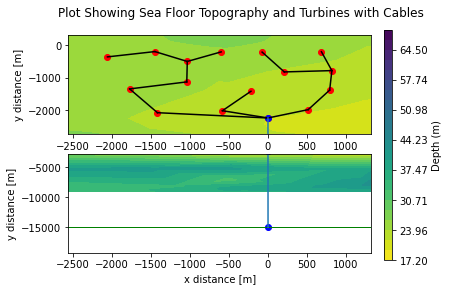

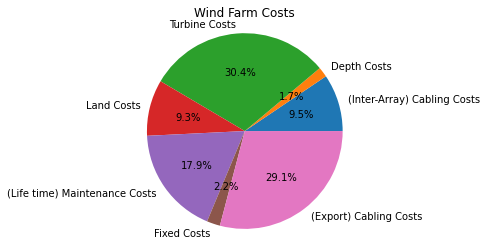

In [271]:
#DISPLAYS OPTIMAL LAYOUT

print('\033[1m'+'\033[4m'+'POST-OPTIMISED LAYOUT INFORMATION'+'\033[0m'+'\033[0m')
print()
OptimizedTPO = smallestTotalCost/smallestCostPerWatt
plotting_function(smallestpositionlist,smallestindiceslist,MSTweight,data,smallestExportCableCost)
OptimizedPayBackTime,OptimizedDiscountedPayBackTime,OptimizedNPV,OptimizedProfIndex = Payback(OptimizedTPO,smallestTotalCost)

print('\033[1m'+'Total Power Output:'+'\033[0m', OptimizedTPO, 'W')
print('\033[1m'+'Cost per Watt'+'\033[0m',smallestCostPerWatt,'£/W')
print('')
print('\033[1m'+'Payback Time:'+'\033[0m',OptimizedPayBackTime,'years')
print('\033[1m'+'Discounted Payback Time:'+'\033[0m',OptimizedDiscountedPayBackTime,'years')
print('\033[1m'+'NPV: £'+'\033[0m',OptimizedNPV,'over a ',LifeTimeTurbineOperatingTime,'year period')
print('\033[1m'+'Profitability Index: £'+'\033[0m',OptimizedProfIndex,'over a ',LifeTimeTurbineOperatingTime,'year period')

In [272]:
# 8 turbines produce 6MW of output, which is 37.5% of their max output, which is roughly correct.
# If the wind speed decreases by half, power production decreases by a factor of eight.
# On average, therefore, wind turbines do not generate near their capacity.
# Industry estimates project an annual output of 30-40%, but real-world experience shows that
# annual outputs of 15-30% of capacity are more typical in a year. Therefore this improved 37.5% is good.